In [7]:
# ---- Configure paths (EDIT THESE) ----
PARQUET_PATH = "../../data/processed/voom_transformed_data.parquet"              # matrix with features only (rows = samples)
TISSUE_DUMMIES_CSV = "../02_feature_engineering/feature_engineering/processed_tissue_dummies.csv"

N_PCS = 30
OUTDIR = "pc_tissue_results"

# Optional (Task: ΔR² vs tissue predictability)
DRUG_WITH_TISSUE_CSV = None   # e.g., "per_drug_with_tissue.csv"
DRUG_NO_TISSUE_CSV   = None   # e.g., "per_drug_without_tissue.csv"
DRUG_SAMPLE_MAP_CSV  = None   # e.g., "drug_sample_map.csv" (drug_id, SANGER_MODEL_ID)

# ---- Imports ----
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, f1_score,
    balanced_accuracy_score, silhouette_score
)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
plt.rcParams["figure.dpi"] = 150

Path(OUTDIR).mkdir(parents=True, exist_ok=True)
print("Output dir:", Path(OUTDIR).resolve())


Output dir: /home/guests3/gba/thesis_implementation/thesis_implementation/bulk_state_of_the_art/notebooks/03_analysis/pc_tissue_results


In [10]:
# --- Robust keyed merge on SANGER_MODEL_ID (handles duplicate ID columns) ---

import re
import numpy as np
import pandas as pd
from pathlib import Path

# 1) Load voom features
voom_df = pd.read_parquet(PARQUET_PATH)

# Find all columns that look like SANGER_MODEL_ID (case-insensitive)
sid_like_cols = [c for c in voom_df.columns if c.lower() == "sanger_model_id"]

if len(sid_like_cols) == 0:
    # Maybe the index holds the IDs
    if voom_df.index.name and voom_df.index.name.lower() == "sanger_model_id":
        sid_series = voom_df.index.to_series()
        voom_df = voom_df.reset_index()  # bring ID into a column
        # after reset, it's now a column with original name
        sid_like_cols = [voom_df.columns[0]]
    else:
        raise ValueError(
            "Could not find SANGER_MODEL_ID in voom parquet (neither a column nor an index). "
            "If it's under another name, rename it or tell me the exact column name."
        )

# If there are duplicates, collapse them to a single Series:
# - prefer the first non-null across duplicate columns
if len(sid_like_cols) > 1:
    # keep a single canonical column (first), fill from others if first has NaNs
    sid_frame = voom_df[sid_like_cols].astype(str)
    sid_series = sid_frame.bfill(axis=1).iloc[:, 0]
    # drop the extra duplicate columns (keep the first as canonical)
    voom_df = voom_df.drop(columns=sid_like_cols[1:])
    canonical_sid_col = sid_like_cols[0]
    voom_df[canonical_sid_col] = sid_series
else:
    canonical_sid_col = sid_like_cols[0]
    sid_series = voom_df[canonical_sid_col].astype(str)

# Normalize canonical name exactly to 'SANGER_MODEL_ID'
if canonical_sid_col != "SANGER_MODEL_ID":
    voom_df = voom_df.rename(columns={canonical_sid_col: "SANGER_MODEL_ID"})
    canonical_sid_col = "SANGER_MODEL_ID"

# 2) Load tissues and prepare labels
tissue_df = pd.read_csv(TISSUE_DUMMIES_CSV)
assert "SANGER_MODEL_ID" in tissue_df.columns, "Tissue file must include SANGER_MODEL_ID."
tissue_df["SANGER_MODEL_ID"] = tissue_df["SANGER_MODEL_ID"].astype(str)

tissue_cols = [c for c in tissue_df.columns if c.startswith("Tissue_")]
assert len(tissue_cols) > 0, "No 'Tissue_*' columns found in tissue dummies CSV."

# Keep rows with exactly one active tissue
tissue_df = tissue_df.loc[(tissue_df[tissue_cols].sum(axis=1) == 1)].copy()
tissue_df["tissue"] = (
    tissue_df[tissue_cols].idxmax(axis=1).str.replace("Tissue_", "", regex=False)
)

# 3) Build numeric feature matrix and inner-join by ID
voom_num = voom_df.drop(columns=["SANGER_MODEL_ID"], errors="ignore").select_dtypes(include=[np.number]).copy()
voom_num["SANGER_MODEL_ID"] = voom_df["SANGER_MODEL_ID"].astype(str).values  # <-- now a single Series

matched = tissue_df[["SANGER_MODEL_ID", "tissue"]].merge(
    voom_num, on="SANGER_MODEL_ID", how="inner"
)

# Deduplicate IDs if needed
matched = matched.drop_duplicates(subset="SANGER_MODEL_ID", keep="first")

# 4) Final arrays
sample_ids = matched["SANGER_MODEL_ID"].to_numpy()
y = matched["tissue"].astype(str).to_numpy()
X = matched.drop(columns=["SANGER_MODEL_ID", "tissue"]).to_numpy()

print(
    f"Matched samples: {len(sample_ids)} | #tissues: {len(np.unique(y))} | "
    f"Feature dim: {X.shape[1]}"
)


Matched samples: 1362 | #tissues: 15 | Feature dim: 37602


In [11]:
scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X)

pca = PCA(n_components=N_PCS, random_state=42)
X_pcs = pca.fit_transform(Xz)

pcs_df = pd.DataFrame(X_pcs, columns=[f"PC{i+1}" for i in range(N_PCS)])
pcs_df["SANGER_MODEL_ID"] = sample_ids
pcs_df["tissue"] = y

expl_var = pca.explained_variance_ratio_
print("Explained variance (first 5 PCs):", np.round(expl_var[:5], 3))
pcs_df.head()


Explained variance (first 5 PCs): [0.255 0.077 0.028 0.023 0.018]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,SANGER_MODEL_ID,tissue
0,36.680137,-108.916730,56.473691,0.771919,-11.637780,-13.142316,6.079679,-5.963701,18.913293,-6.459810,...,6.638627,16.156279,-11.605182,8.449281,-1.381387,2.351920,-6.035632,-4.065383,SIDM00001,Haematopoietic And Lymphoid
1,-133.362960,-134.214713,-4.774935,26.812084,35.160123,21.054091,14.802906,-14.423738,-21.986601,-1.122292,...,11.436827,-10.600912,10.794464,-1.595011,-7.773263,14.834627,-1.964793,-0.329101,SIDM00002,Peripheral Nervous System
2,-167.013738,-135.754860,-15.002974,13.782977,-15.402915,23.097619,-14.083559,48.643579,4.459391,-10.701415,...,14.867236,6.868667,-1.226268,-10.181182,-19.426838,-4.952759,-2.425185,-7.794106,SIDM00003,Skin
3,60.007001,-117.317987,1.873497,15.408201,42.603928,-21.950439,28.109972,0.958338,-24.287058,2.936561,...,0.094292,32.322350,-6.721867,-6.239562,-14.265226,-5.260007,10.185986,-0.584674,SIDM00005,Breast
4,-153.725113,-131.039516,-31.551507,33.446173,4.572226,14.449591,13.872287,-3.370174,14.243639,-12.150304,...,11.218822,-9.925002,7.465460,-7.720456,3.263039,-1.319931,-25.993713,10.562543,SIDM00006,Skin


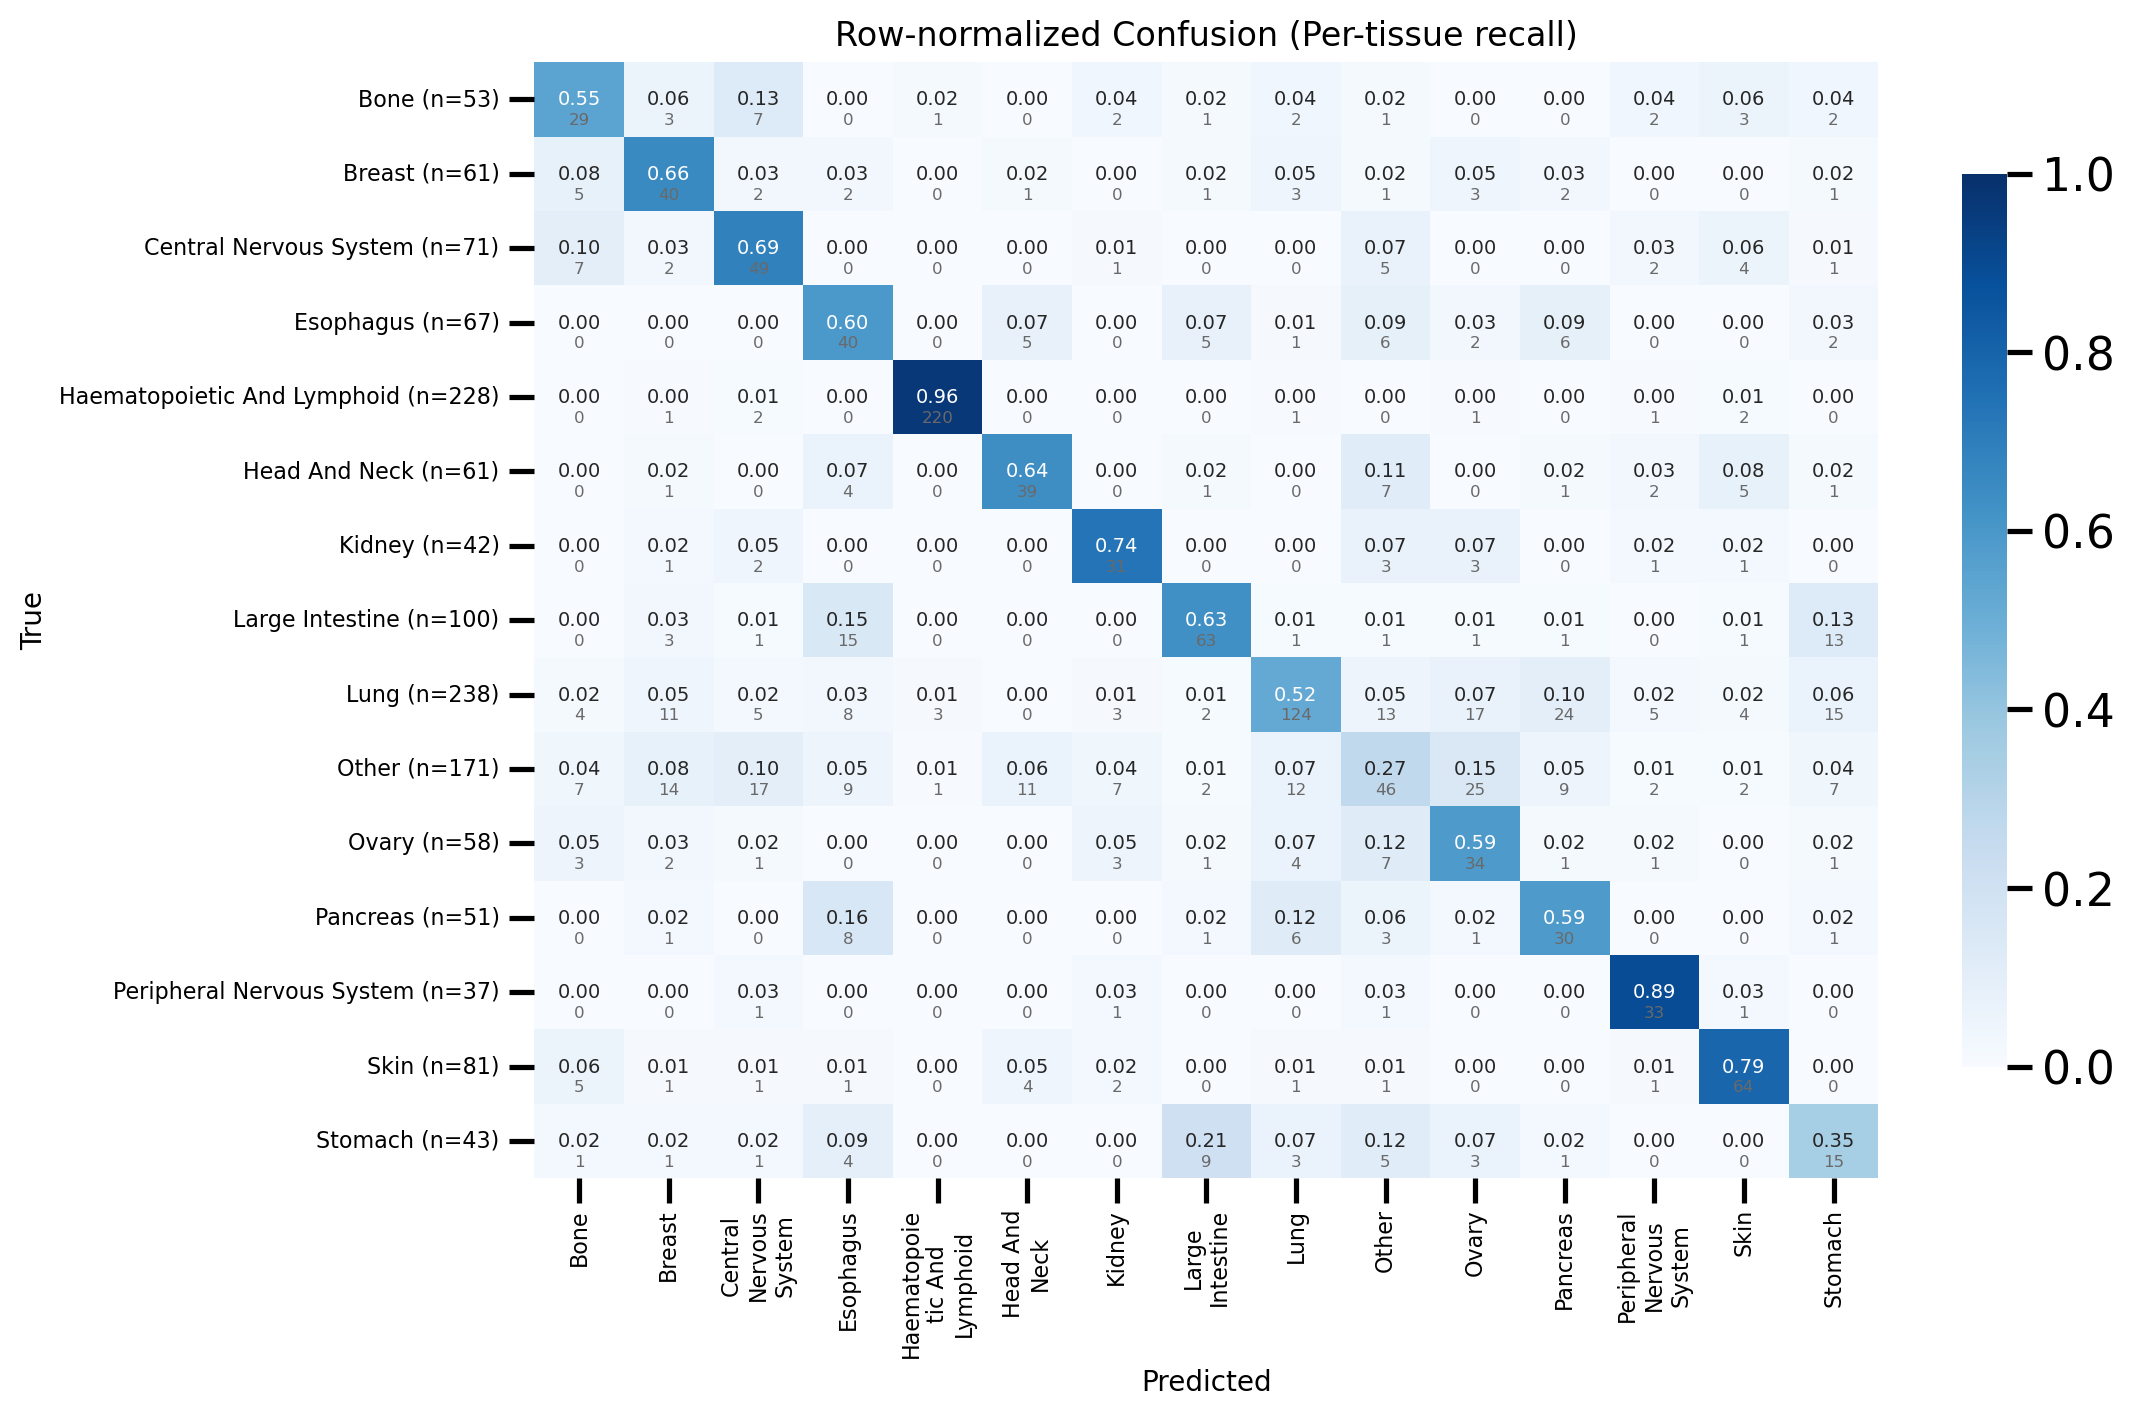

In [20]:
# Vertical, multi-line x labels + annotations + counts

import textwrap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# y-axis labels with class sizes
row_counts = cm.sum(axis=1)
labels_y = [f"{lab} (n={int(n)})" for lab, n in zip(labels, row_counts)]

# wrap x labels into multiple lines, then rotate vertically
def wrap_multiline(s, width=11):
    return "\n".join(textwrap.wrap(str(s), width=width))

x_wrapped = [wrap_multiline(lab, width=11) for lab in labels]

fig, ax = plt.subplots(figsize=(12, 9), dpi=200)

sns.heatmap(
    cm_row,
    xticklabels=x_wrapped,
    yticklabels=labels_y,
    cmap="Blues",
    vmin=0, vmax=1,
    annot=True, fmt=".2f",           # show row-normalized values
    annot_kws={"size":7},
    cbar_kws={"shrink":0.8},
    ax=ax,
)

# overlay raw counts (optional; comment out to hide)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j + 0.5, i + 0.78, f"{cm[i, j]}",
                ha="center", va="center", fontsize=6, color="dimgray")

ax.set_title("Row-normalized Confusion (Per-tissue recall)", fontsize=12)
ax.set_xlabel("Predicted", fontsize=10)
ax.set_ylabel("True", fontsize=10)

# make x labels vertical and centered
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha("center")  # center horizontally after rotation
    tick.set_va("top")     # align tops so multi-line stacks nicely
    tick.set_multialignment("center")

# smaller ticks; give extra bottom margin for the multi-line vertical labels
ax.tick_params(axis="x", labelsize=8, pad=2)
ax.tick_params(axis="y", labelsize=8)
plt.subplots_adjust(bottom=0.28, left=0.28, right=0.98, top=0.90)

plt.savefig(Path(OUTDIR, "confusion_row_norm_vertical_multiline.png"), bbox_inches="tight")
plt.show()


Median η² across PCs = 0.126 (IQR 0.052–0.238)
Top PCs by η²:


,PC,eta2
2,PC3,0.840930
3,PC4,0.564537
7,PC8,0.336383


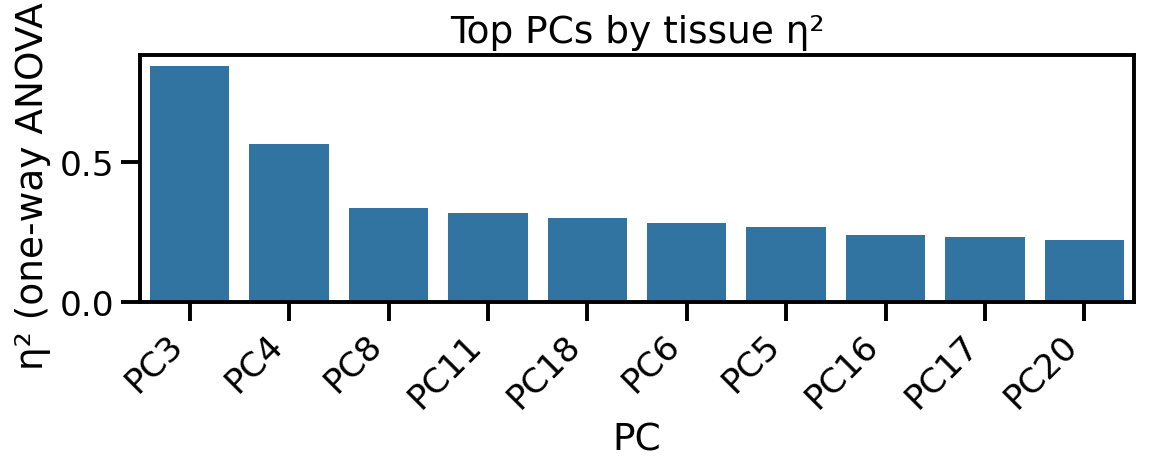

In [13]:
from collections import defaultdict

def eta_squared_oneway(values, groups):
    """Compute eta-squared for one-way ANOVA: SS_between / SS_total."""
    vals = np.asarray(values, float)
    g = np.asarray(groups)
    # overall mean
    grand_mean = np.nanmean(vals)
    # group means and sizes
    ss_between, ss_total = 0.0, 0.0
    for grp in np.unique(g):
        mask = (g == grp)
        if not np.any(mask): 
            continue
        m = np.nanmean(vals[mask])
        n = np.sum(mask)
        ss_between += n * (m - grand_mean) ** 2
    ss_total = np.nansum((vals - grand_mean) ** 2)
    return ss_between / ss_total if ss_total > 0 else np.nan

eta2 = []
for k in range(N_PCS):
    pc_vals = X_pcs[:, k]
    eta2_k = eta_squared_oneway(pc_vals, y)
    eta2.append(eta2_k)

eta2 = np.array(eta2)
eta_df = pd.DataFrame({"PC": [f"PC{i+1}" for i in range(N_PCS)], "eta2": eta2})
eta_df.to_csv(Path(OUTDIR, "pc_eta2_by_tissue.csv"), index=False)

med = np.nanmedian(eta2)
q25, q75 = np.nanpercentile(eta2, [25, 75])
top3 = eta_df.sort_values("eta2", ascending=False).head(3)

print(f"Median η² across PCs = {med:.3f} (IQR {q25:.3f}–{q75:.3f})")
print("Top PCs by η²:")
display(top3)

# Tiny bar plot of top 10 PCs by η² (optional)
topN = 10
plt.figure(figsize=(8, 3.5))
sns.barplot(data=eta_df.sort_values("eta2", ascending=False).head(topN), x="PC", y="eta2")
plt.ylabel("η² (one-way ANOVA)")
plt.title("Top PCs by tissue η²")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(Path(OUTDIR, "pc_eta2_top10.png")); plt.show()


In [14]:
# Silhouette in PC space (higher = more separable)
try:
    sil = silhouette_score(X, y, metric="euclidean")
    print(f"Silhouette score by tissue (PC space): {sil:.3f}")
except Exception as e:
    print("Silhouette computation failed:", e)


Silhouette score by tissue (PC space): -0.088


In [15]:
# From earlier cells:
#   macro_f1, bal_acc, pairs_sorted (hardest confusions), eta2 (array), med, q25, q75

hard_pairs = ", ".join([f"{a}↔{b}" for a,b,_ in pairs_sorted[:3]]) if len(pairs_sorted) else "—"

print("Earned sentence 1:")
print(f"PCs predict tissue with macro-F1 ≈ {macro_f1:.2f} and balanced accuracy ≈ {bal_acc:.2f}; "
      f"hardest confusions occur among {{{hard_pairs}}}.")

print("\nEarned sentence 2:")
print(f"Median η² across PCs = {med:.2f} (IQR {q25:.2f}–{q75:.2f}), indicating that a sizeable fraction "
      f"of variance is explained by tissue, but not all.")

# If ΔR² correlation computed, it was printed in Cell 7; you can paraphrase as needed.
print("\nNote: If you provided per-drug results and a drug→sample map, the ΔR² correlation line "
      "was computed and printed above.")


Earned sentence 1:
PCs predict tissue with macro-F1 ≈ 0.59 and balanced accuracy ≈ 0.63; hardest confusions occur among {Stomach↔Large Intestine, Pancreas↔Esophagus, Large Intestine↔Esophagus}.

Earned sentence 2:
Median η² across PCs = 0.13 (IQR 0.05–0.24), indicating that a sizeable fraction of variance is explained by tissue, but not all.

Note: If you provided per-drug results and a drug→sample map, the ΔR² correlation line was computed and printed above.


In [16]:
with open(Path(OUTDIR, "quick_report.txt"), "w") as f:
    f.write(f"Macro-F1: {macro_f1:.3f}\nBalanced Acc: {bal_acc:.3f}\n")
    f.write(f"Silhouette (PC space): {sil if 'sil' in locals() else np.nan:.3f}\n")
    f.write(f"Median eta2: {med:.3f} | IQR: {q25:.3f}-{q75:.3f}\n")
    if len(pairs_sorted):
        f.write("Top confusions:\n")
        for a,b,v in pairs_sorted[:5]:
            f.write(f"  {a}->{b}: {v:.3f}\n")
print("Saved:", Path(OUTDIR, "quick_report.txt"))


Saved: pc_tissue_results/quick_report.txt


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


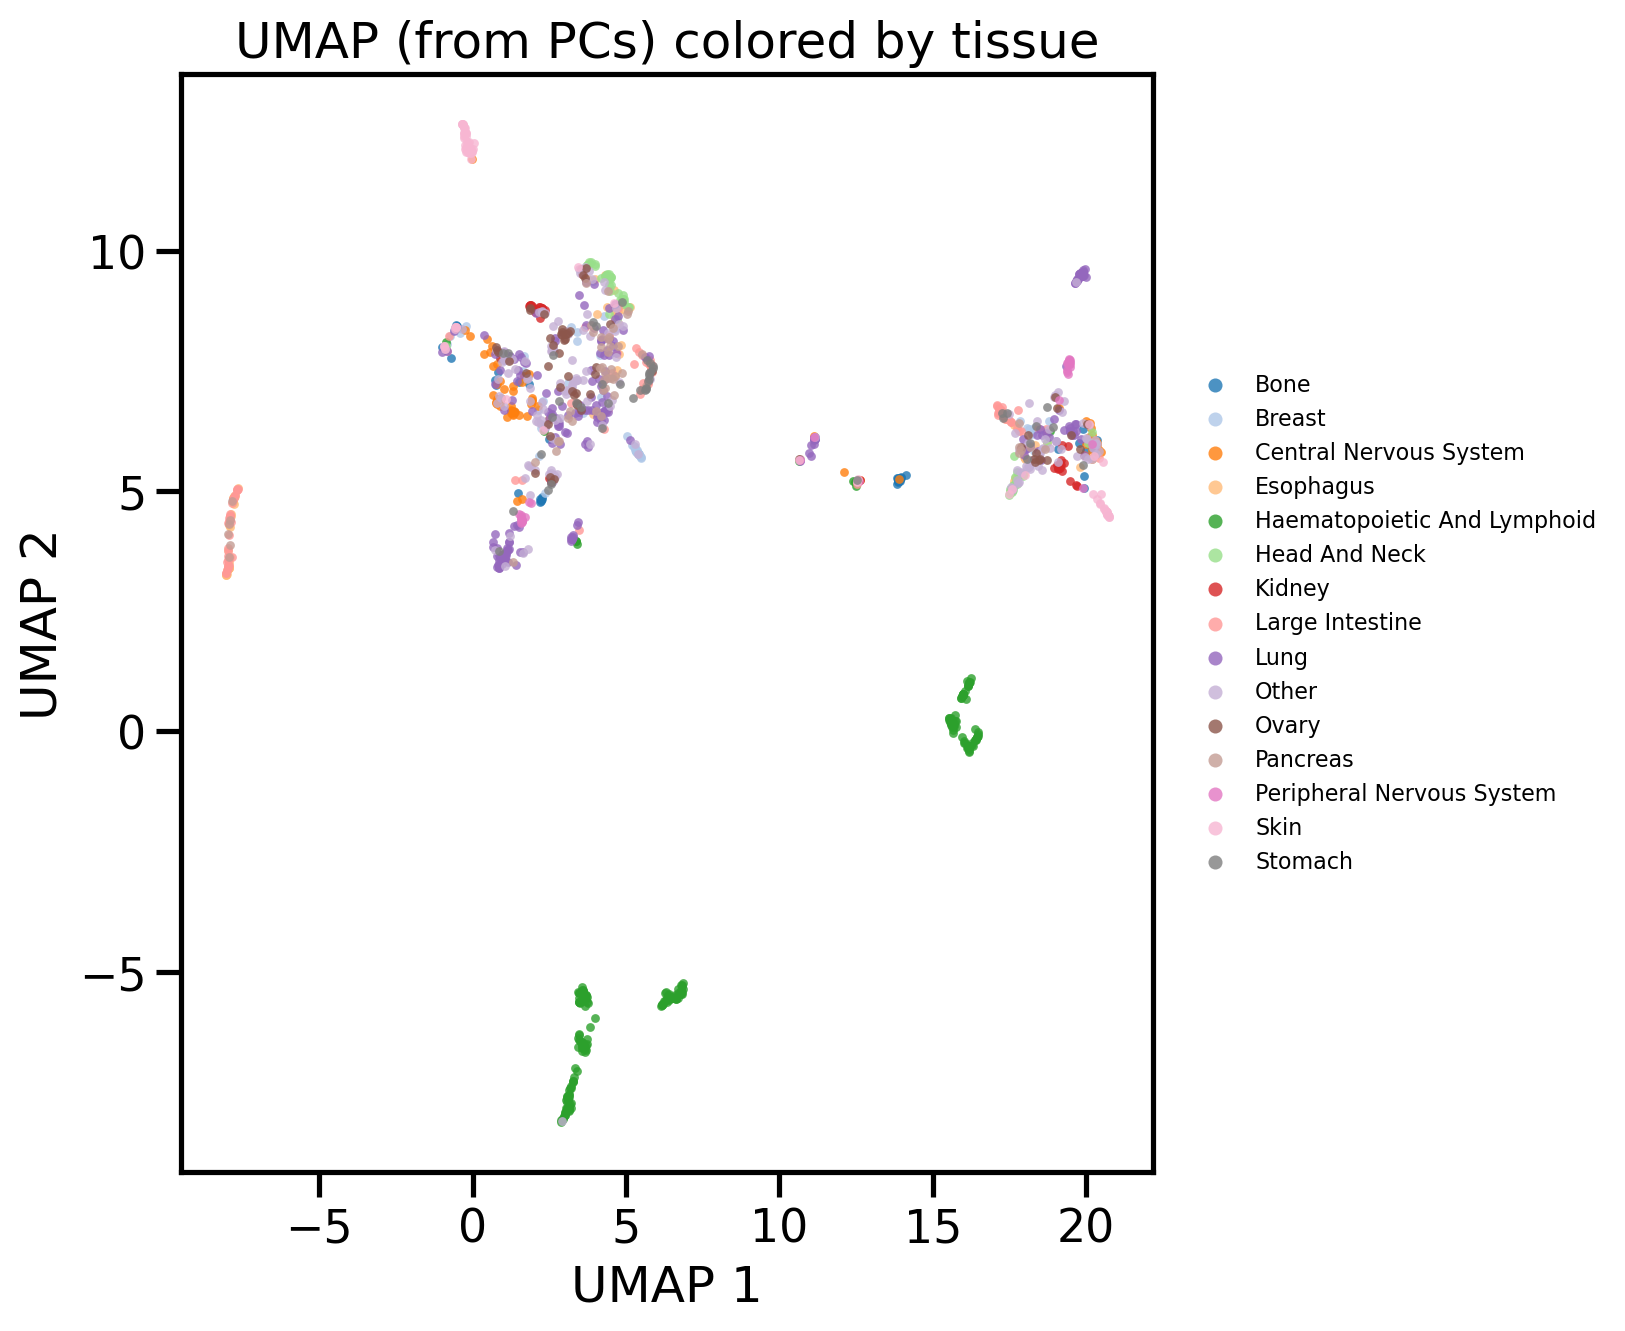

Saved UMAP CSV and PNG in: /home/guests3/gba/thesis_implementation/thesis_implementation/bulk_state_of_the_art/notebooks/03_analysis/pc_tissue_results


In [21]:
# UMAP (on PCs) colored by tissue
# Requires: variables X_pcs (from your PCA), y (tissue labels), sample_ids

# 1) Import / install hint
try:
    import umap
except ImportError as e:
    raise ImportError("umap-learn is not installed. Do:  pip install umap-learn") from e

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 2) Optional subsample to keep the plot readable (set to None to use all)
MAX_POINTS = None  # e.g., 8000

if MAX_POINTS is not None and len(y) > MAX_POINTS:
    rng = np.random.default_rng(42)
    sel = rng.choice(len(y), size=MAX_POINTS, replace=False)
    X_plot = X_pcs[sel]
    y_plot = np.array(y)[sel]
    ids_plot = np.array(sample_ids)[sel]
else:
    X_plot = X_pcs
    y_plot = np.array(y)
    ids_plot = np.array(sample_ids)

# 3) Fit UMAP on PCs
um = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    n_components=2,
    random_state=42,
)
U = um.fit_transform(X_plot)

# 4) Pack into a DataFrame and save
umap_df = pd.DataFrame({
    "UMAP1": U[:, 0],
    "UMAP2": U[:, 1],
    "tissue": y_plot,
    "SANGER_MODEL_ID": ids_plot,
})
umap_df.to_csv(Path(OUTDIR, "umap_pc2_colored_by_tissue.csv"), index=False)

# 5) Plot — compact legend, consistent colors
labels_unique = np.unique(y_plot)
palette = sns.color_palette("tab20", n_colors=len(labels_unique))
color_map = {lab: palette[i % len(palette)] for i, lab in enumerate(labels_unique)}

fig, ax = plt.subplots(figsize=(8.5, 7), dpi=200)
for lab in labels_unique:
    mask = (y_plot == lab)
    ax.scatter(
        U[mask, 0], U[mask, 1],
        s=10, alpha=0.8, linewidths=0,
        c=[color_map[lab]], label=lab
    )

ax.set_xlabel("UMAP 1"); ax.set_ylabel("UMAP 2")
ax.set_title("UMAP (from PCs) colored by tissue")

# Legend outside the plot area, compact columns
leg = ax.legend(
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    ncol=1, frameon=False, markerscale=1.6, fontsize=8
)

plt.tight_layout()
plt.savefig(Path(OUTDIR, "umap_pc2_by_tissue.png"), bbox_inches="tight")
plt.show()

print("Saved UMAP CSV and PNG in:", Path(OUTDIR).resolve())
